We consider k components a Bernoulli variable with a probability $\theta_k$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from os.path import getctime
import glob
import os
import random
import subprocess
import sys
import multiprocessing
from scipy.optimize import curve_fit
from scipy import interpolate
from pathlib import Path
import math

class SimFile(object):
    def __init__(self, file_name):
        self.file_name = file_name
      
    def __enter__(self):
        self.file = open(self.file_name)
        return json.load(self.file)
  
    def __exit__(self, exc_type, exc_value, exc_tb):
        self.file.close()

def getsims(q, n, latest=False, pre="sim_data"):
    #print("simdata/q{:.4f}/n{}/sim_*".format(q, n))
    if not latest:
        return glob.glob("simdata/q{:.4f}/n{}/{}_*".format(q, n, pre))
    else:
        return max(glob.glob("simdata/q{:.4f}/n{}/{}_*".format(q, n, pre)), key=getctime)

def getanalysis(q, n):
    return glob.glob("simdata/q{:.4f}/n{}/dist.pkl".format(q, n))


class SimData(object):
    def __init__(self, q, n, susceptibility=False):
        self.q = q
        self.n = n
        self.susceptibility = susceptibility
      
    def __enter__(self):
        self.files = []
        data = []
        for sim_path in getsims(self.q, self.n, pre="sim_datastring" if self.susceptibility else "sim_data"):
            file = open(sim_path)
            self.files.append(file)
            data.append(json.load(file))

        return data
  
    def __exit__(self, exc_type, exc_value, exc_tb):
        for file in self.files:
            file.close()


class SimDiagnostics(object):
    def __init__(self, q, n):
        self.q = q
        self.n = n
      
    def __enter__(self):
        self.files = []
        data = []
        for sim_path in getsims(self.q, self.n, pre="sim_diagnostics"):
            file = open(sim_path)
            self.files.append(file)
            data.append(json.load(file))

        return data
  
    def __exit__(self, exc_type, exc_value, exc_tb):
        for file in self.files:
            file.close()

class SimAnalysis(object):
    def __init__(self, q, n):
        self.q = q
        self.n = n
        self.file_name = getanalysis(q, n)[0]
      
    def __enter__(self):
        return pd.read_pickle(self.file_name)
  
    def __exit__(self, exc_type, exc_value, exc_tb):
        pass



In [21]:
import seaborn as sns
palette = sns.color_palette("tab10", as_cmap=True)

sns.set_theme()
sns.set_style("ticks")
sns.set_palette(sns.color_palette("RdYlBu"))

In [3]:
def rescale(x, y, k):
    return [x*k, y/k]


def rescale_haus(y, N, dH, x=None):
    if not x:
        x = np.arange(len(y))
    return [x*N**(-1/dH), y*N**(1/dH)]

def fitfunc(dH, curves, f0):

    f = interp1d(np.arange(Nbins), value, kind='cubic', bounds_error=False, fill_value=0)

    # yvals = []

    # x = np.linspace(0, Nbins-1, 200)

    # for (key, value) in curves.items():
    #     N = key
    #     f = interp1d(np.arange(Nbins), value, kind='cubic', bounds_error=False, fill_value=0)
    #     yvals.append(f(x*N**(1/dH))*N**(1/dH))

    # yvals = np.array(yvals)

    #print(yvals)

    #print(np.std(yvals, axis=0))

    #plt.plot(x,np.std(yvals, axis=0))
    return np.sum(np.std(yvals, axis=0))

#fitfunc(3.56)


### The relation between central charge c and $d_H$
For $c \in (-\infty, 1]$

$d_H = 2 \frac{\sqrt{25-c}+\sqrt{49-c}}{\sqrt{25-c}+\sqrt{1-c}}$

For $c > 1$, $d_H  = 2$

In [7]:
def conjectured_hausdorff(c):
    if c <= 1:
        return 2*(np.sqrt(25-c)+np.sqrt(49-c)) / (np.sqrt(25-c)+np.sqrt(1-c))
    else:
        return 2

def string_susceptibility(c):
    if c <= 1:
        return (c-1-np.sqrt((c-1)*(c-25)))/12
    else:
        return 1/2

string_susceptibility = np.vectorize(string_susceptibility)

There is also a relation between the weight per component $q$ and the central charge $c$.

$n = 2 \cos{\pi e} \rightarrow e = \frac{1}{\pi}\arccos{\frac{n}{2}}$

$c(n) = 1 - 6 \frac{e^2}{1-e}$

In [4]:
def central_charge(q):
    e = (1.0/np.pi)*np.arccos(q/2.0)
    
    return -1.0-(6.0*(e**2.0))/(1.0-e)


print("q = 2 yields c =", central_charge(2), "dH =", conjectured_hausdorff(central_charge(2)), "sus=", string_susceptibility(central_charge(2)))
print("q = 1 yields c =", central_charge(1), "dH =", conjectured_hausdorff(central_charge(1)), "sus=", string_susceptibility(central_charge(1)))
print("q = 0 yields c =", central_charge(0), "dH =", conjectured_hausdorff(central_charge(0)), "sus=", string_susceptibility(central_charge(0)))

q = np.linspace(0, 10, 100)

print(central_charge(q))



q = 2 yields c = -1.0 dH = 3.7370341836426597 sus= -0.7675918792439983
q = 1 yields c = -2.0 dH = 3.5615528128088307 sus= -1.0
q = 0 yields c = -4.0 dH = 3.323681366077776 sus= -1.4201328815660246
[-4.         -3.72253326 -3.46704417 -3.23110653 -3.01266145 -2.80995038
 -2.6214627  -2.44589448 -2.28211565 -2.1291439  -1.98612378 -1.85231034
 -1.7270564  -1.60980338 -1.50007578 -1.39748035 -1.30171221 -1.21257487
 -1.13003458 -1.05439886         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan


/tmp/ipykernel_15852/892599043.py:2: RuntimeWarning: invalid value encountered in arccos
  e = (1.0/np.pi)*np.arccos(q/2.0)


In [22]:
q = np.linspace(0, 4, 100)

stringsus = string_susceptibility(central_charge(q))
with plt.style.context('dark_background'):
    plt.plot(q, stringsus)
    plt.xlabel("$q$")
    plt.ylabel("$\gamma$ string susceptibility")
    plt.tight_layout()
    plt.savefig("stringsusvsq.pdf")
    
    
    #plt.grid()

/tmp/ipykernel_15852/892599043.py:2: RuntimeWarning: invalid value encountered in arccos
  e = (1.0/np.pi)*np.arccos(q/2.0)


In [6]:
def run_sim(q, n, configurations, iterations, dump=False):
   Path("/simdata/q{:.4f}/n{}".format(q, n)).mkdir(parents=True, exist_ok=True)
   cmd = "./build/meander_main -q {} -n {} -i {} -s {} -y {} {}".format(q, n, iterations, configurations, random.randint(0, 2**30), "-d" if dump else "")
   !{cmd}


In [ ]:
n = 1024
run_sim(q=1.0, n=n, configurations=400, iterations=n*256) # relaxation time is at least 64 times n

In [ ]:
# test runner

def run(n):
    run_sim(q=2.0, n=n, configurations=1, iterations=n*2**16, dump=True) # relaxation time is at least 64 times n

pool_obj = multiprocessing.Pool()
pool_obj.map(run, [64])

In [ ]:

def run(n):
    q = 2.0
    run_sim(q=q, n=n, configurations=200, iterations=n*256*int(q)) # relaxation time is at least 64 times n

pool_obj = multiprocessing.Pool()
pool_obj.map(run, [1024, 2048])

In [ ]:
n = 8192
run_sim(q=1.0, n=n, configurations=400, iterations=n*256) # relaxation time is at least 64 times n

In [ ]:
#file = getsims(q=1, n=2**6, latest=True)

q = 0.125
n = 16384

with SimData(q=q, n=n) as measurements:
    dist = []

    for data in measurements:
        #print(data["dist"])
        dist.append(data["dist"])
    
    df = pd.DataFrame(data=dist)
    df = df.fillna(0)
    
    #print(df)
    sum_res = df.sum(axis=0)
    #res = np.sum(dist, axis=0)
    plt.plot(sum_res)
    plt.title("acceptance rate: {}".format(data["accepted"]/data["iter"]))

    sum_res.to_pickle("simdata/q{:.4f}/n{}/dist.pkl".format(q, n))
    #print(res)
    #plt.plot(np.arange(len(res)),res)
    # for i in dist:
    #     plt.plot(np.arange(len(i)), i)
    # print(dist)
        #d[]




In [7]:
size_data = {2.0: [64, 256, 512, 1024, 2048, 4096, 8192, 16384],
             1.0: [64, 256, 512, 1024, 2048, 4096, 8192, 16384],
             0.5: [128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536],
             0.25: [256, 512, 1024, 2048, 4096, 8192, 16384],
             0.125: [256, 512, 1024, 2048, 4096, 8192, 16384]}

In [8]:
q = 0.5

sizes = size_data[q]

for n in sizes:
    with SimAnalysis(q=q, n=n) as measurement:
        area = np.trapz(measurement)
        p = measurement/area
        plt.plot(p*n*2)
    


    plt.title("Distance histogram/dual graph distance")
    plt.xlabel("$r$")
    plt.ylabel("$N \\cdot \\rho_N(r)$")


In [ ]:
q = 0.5
dH = 4

sizes = size_data[q]

for n in sizes:
    with SimAnalysis(q=q, n=n) as measurement:
        area = np.trapz(measurement)
        p = measurement/area
        plt.plot(p*n*2)
        x, y = rescale_haus(y, n*2, dH)
    


    plt.title("Distance histogram/dual graph distance")
    plt.xlabel("$r$")
    plt.ylabel("$N \\cdot \\rho_N(r)$")

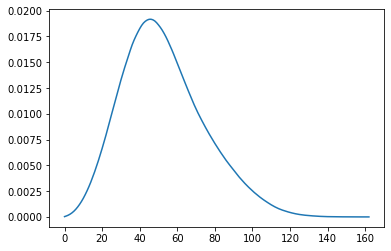

0.08087716886608015
[4.19935199] [[0.00178151]]
0.06561629824132878
[3.26464859] [[0.00142447]]
0.05076839133089133
[2.56478302] [[0.00036425]]
0.04375179312660237
[2.04092014] [[0.0008057]]
0.03237540438259171
[1.60101205] [[0.00014538]]
0.026780030213324382
[1.28815505] [[0.00010769]]
0.019167760229902596
[1.] [[0.]]
conjectured dH = 3.185672764182965
average, dH 2.894847734218835


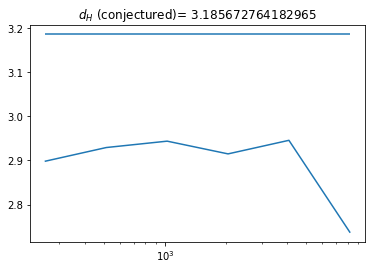

In [9]:
q = 0.125

sizes = size_data[q]

with SimAnalysis(q=q, n=sizes[-1]) as measurement:
    p = measurement/np.trapz(measurement)
    x0 = np.arange(len(p))
    f0 = interpolate.interp1d(x0, p)

plt.plot(x0, f0(x0))
plt.show()

def hausfit(x, k):
    global f0
    try:
        val = f0(k*x)
    except:
        val = 0
    return val*k

ks = []

for n in sizes:
    with SimAnalysis(q=q, n=n) as measurement:
        area = np.trapz(measurement)
        p = measurement/area

        max_val = np.max(p)
        print(max_val)
        x = np.arange(len(p))
        p_ = p[p>max_val/5]
        x_ = x[p>max_val/5]
        
        popt, pcov = curve_fit(hausfit, x_, p_)
        k = popt[0]

        ks.append(k)
        print(popt, pcov)



n_ = np.array(sizes[:-1])
k_ = np.array(ks[:-1])

y = np.log(sizes[-1]/n_)/np.log(k_)

plt.plot(n_, y)
conj_hausdorff_dim = conjectured_hausdorff(central_charge(q)-2)
plt.hlines(conj_hausdorff_dim, np.min(n_), np.max(n_))
print("conjectured dH =", conj_hausdorff_dim)
plt.title("" + "$d_H$ (conjectured)" + "= ${}$".format(conj_hausdorff_dim))
plt.xscale("log")
dH_mean = np.mean(y)

print("average, dH", dH_mean)


In [ ]:
# Checking the Hausdorff dimension

q = 2.0

dH = y[-1]

sizes = [64, 256, 512, 1024, 2048, 4096, 8192, 16384]

for n in sizes:
    with SimAnalysis(q=q, n=n) as measurement:
        area = np.trapz(measurement)
        p = measurement/area
        plt.plot(*rescale_haus(y=p, N=2*n, dH=dH))
        
    

    
plt.title("Distance histogram $d_H = {}$".format(dH))
plt.xlabel("$r$")
plt.ylabel("$N \\cdot \\rho_N(r)$")

In [2]:
def split_array_in_batches(arr, batch_size):
    remainder = arr.shape[0] % batch_size

    # back of array will be cut if batch size does not fit the length.
    return arr[:-remainder].reshape(int((arr.shape[0]-remainder)/batch_size), batch_size)

In [3]:
def error(sequence, k, batch_size):
    c = np.where(sequence == k, 1, 0)
    
    #print(k, sequence)

    #length = len(c)

    



    #n_batches = int(length/batch_size)

    #print("batches:", n_batches, "size of batch:", batch_size)

    #c = c.reshape((int(length/batch_size), batch_size))
    c = split_array_in_batches(c, batch_size)

    n_batches = c.shape[1]

    means = np.mean(c, axis=1)

    mean = np.mean(means)

    squared_sum = np.sum(np.square(means))/n_batches
    sum_squared = np.square(np.sum(means/n_batches))

    err = (1/(np.sqrt(n_batches)))*np.sqrt(squared_sum-sum_squared) 
    
    return [mean, err]

# Error plot
def errordata(k):
    k = np.array(k)
    max_iter_log2 = int(np.log2(len(k)))

    x = np.power(2, np.arange(5, max_iter_log2))
    y = np.zeros(x.shape)
    yerr = np.zeros(x.shape)

    avg = int(np.mean(k))

    for i, batches in enumerate(x):
        
        mean, std = error(k, avg, batches)

        y[i] = mean
        yerr[i] = std

    return [x, yerr, y]

def diagnostics_dataframe(data):
    d = {
        "n": data["n"],
        "q": data["q"],
        "iterations": data["iterations"],
        "accepted": data["accepted"],
        "acceptance rate": float(data["accepted"])/float(data["iterations"]),
        "seed": data["seed"],
        "version": data["version"],
        "date": data["date"],
        "type": data["type"],
        "time_flipping": data["time_flipping"],
        "time_measuring": data["time_measuring"],
        "tmeasure/tflipping": float(data["time_measuring"])/float(data["time_flipping"])
    }

    return pd.DataFrame.from_dict(d, orient='index')

def histogram_to_coordinates(hist, hist_sq):
    vals = []
    for i, (val, val_sq) in enumerate(zip(hist, hist_sq)):
        if val != 0:
            vals.append(np.array([i+1, val, val_sq]))
    return np.array(vals)

def add_string_hist(data, N):
    arr = np.zeros(N)
    arr_sq = np.zeros(N)
    n_indep = 0
    
    for row in data:
        if not "N" in row.keys():
            print(row)
        n_indep += row["N"]
        for [x, y, y_sq] in row["stringhist"]:
           # print(x, y)
            arr[int(x-1)] += y
            arr_sq[int(x-1)] += y_sq
    
    return [n_indep, histogram_to_coordinates(arr, arr_sq)]


def histogram_to_coordinatesv2(hist, hist_sq):
    vals = []
    for i, (val, val_sq) in enumerate(zip(hist, hist_sq)):
        if val != 0:
            vals.append(np.array([i+1, val, val_sq]))
    return np.array(vals)

def add_string_histv2(data, N):
    arr = np.zeros(N)
    arr_sq = np.zeros(N)
    n_indep = 0
    for row in data:
        n_indep += row["N"]
        for [x, y, y_sq] in row["stringhist"]:
           # print(x, y)
            arr[int(x-1)] += y
            arr_sq[int(x-1)] += y_sq
    
    return [n_indep, histogram_to_coordinatesv2(arr, arr_sq)]

Case q = 1
| n          | $\tau$ |
|------------|--------|
| 64         | 4096   | 12 -> 12 6
| 256        | 8192   | 13 -> 14 8
| 1024       | 8192   | 13 -> 16 10
| 4096       | 32768  | 15 -> 18 12
| 16384      | 262144 | 18 -> 20 14
| 65536      | 262144 | 18 -> 22 16
| 262144     | 16777216| 24 -> 24 18
|            |        |
|            |        |
|            |        |
|            |        |
|            |        |
|            |        |
|            |        |

for q = 2 seems to be 2x larger

In [4]:
#file = getsims(q=1, n=2**6, latest=True)

q = 1.0
n = 512

with SimData(q=q, n=n) as data:
   # data = data[0]
    data = data[0]
    #print(data.keys())
    print("accept rate", data["accepted"]/data["iter"])

    k = np.array(data["k_by_iterations"])
    
    n = data["n"]

    
    x = np.power(2, np.arange(5, 20))
    y = np.zeros(len(x))
    yerr = np.zeros(len(x))

    #print(error(k, 25, 2))
    avg = int(np.mean(k))

    for i, batches in enumerate(x):
        mean, std = error(k, avg, batches)

        y[i] = mean
        yerr[i] = std



    #np.split(k, )

    plt.plot(x, yerr)
    plt.xscale('log', basex=2)
    plt.show()


IndexError: list index out of range

In [ ]:

with SimFile(file) as data:
    k = np.array(data["k_by_iterations"])

    plt.plot(np.arange(len(k)),k)
    plt.show()

    start = 1*2**23
    end = 1*2**23+2**23

    plt.plot(np.arange(len(k))[start:end],k[start:end])
    #plt.ylim(200, 300)
    plt.show()

In [ ]:
q = 1.0
n = 128

with SimData(q=q, n=n, susceptibility=True) as data:
    data = data[0]
    print("keys", data.keys())
    df = diagnostics_dataframe(data)
df


In [8]:
# string susceptibility helpers
# def fitfunc(x, c, g, b):
#     return np.exp(c) * np.power(x, g-2) * np.exp(b/x)

def fitfunc(x, g, c, e):
    return c + (g-2)*x - e/x

# string partition function
# def spf(n, s, a, d):
#     return n**(s-2)*(1+a*n**(-d))

# def fitfunc(x, s, a, d):
#     n, N = x
#     return spf(x, )

# def fitfuncv2(x, g):
#     return (g-2)*x


def get_std(N, gamma = -1):
    n = np.arange(1, N)

    p = np.power((n * (1-n/N)), gamma - 2)

    y = n * (1-n/N)

    return [p, y, n]

def get_str(N, gamma = -1):
    p, _, n = get_std(N, gamma)
    return [p, n]

def get_str_(N, gamma = -1):
    p, _, n = get_std(N, gamma)
    print(np.array([p, n]).T)
    return [(n * (1-n/N)), p]

def cut(x, p, p_err, cutoff):
    p = p[x >= cutoff]
    p_err = p_err[x >= cutoff]
    x = x[x >= cutoff]
    return [x, p, p_err]

def stringfit(n, p, N, cutoff, logp_err):
    
    
    x = (n * (1-n/N))
    #print(x)
    x, p, logp_err = cut(x, p, logp_err, cutoff)

    popt, pcov = curve_fit(fitfunc, np.log10(x), np.log10(p), sigma=logp_err)
    err = np.sqrt(pcov.diagonal())
    #, p0=[1, -1])#, bounds=([0, -5], [2, 5]))
    #popt, pcov = curve_fit(fitfunc, x, p, bounds=([0, -5, -np.inf], [2, 5, np.inf]))

    return popt, err

def linfitfunc(x, a, b):
    return x*a+b

def string_lin_fit(n, p, N, cutoff, logp_err):
    x = (n * (1-n/N))
    #print(x)
    x, p, logp_err = cut(x, p, logp_err, cutoff)
    
    print("shape-cutoff", x.shape, cutoff)

    popt, pcov = curve_fit(linfitfunc, np.log10(x), np.log10(p), sigma=logp_err)
    err = np.sqrt(pcov.diagonal())
    #z = np.polyfit(np.log10(x), np.log10(p), 1)
    #print(z)

    return popt, err

def exp_fitfunc(x, g, a, b):
    return g + a * np.exp(-b*x)


def exp_fit(x, y, Sy):
    
    #print(x)
    
    
    

    popt = curve_fit(exp_fit, x, y)
    #err = np.sqrt(pcov.diagonal())
    #z = np.polyfit(np.log10(x), np.log10(p), 1)
    #print(z)

    return popt
# def stringfitv2(n, p, N, cutoff):
#     x = (n * (1-n/N))
#     print(x)
#     p = p[x <= cutoff]
#     x = x[x <= cutoff]
#     popt, pcov = curve_fit(fitfuncv2, np.log10(x), np.log10(p))#, p0=[1, -1])#, bounds=([0, -5], [2, 5]))
#     #popt, pcov = curve_fit(fitfunc, x, p, bounds=([0, -5, -np.inf], [2, 5, np.inf]))

#     return popt

In [10]:
q = 0.5
n = 512

%matplotlib osx

def calc_error(arr, arr_sq, N):
    return [1/(np.sqrt(N))*np.sqrt(arr_sq/N - ((1/N)*arr)**2), np.sqrt(arr_sq/N-((1/N)*arr)**2)]




with SimData(q=q, n=n, susceptibility=True) as data:
    N = 2*n

    #data = data[:40]

    # plt.figure(figsize=(12, 8), dpi=80) 

    #print(data[0]["stringhist"], data[0]["N"])

    n_indep, d = add_string_hist(data, N)

    fig, axs = plt.subplots(2, 2)


    print("N =", n_indep)
    #print("d =", d)

    

    x = d.T[0]
    y = d.T[1]

    y_sq = d.T[2]

    y_err, y_std = calc_error(y, y_sq, n_indep)

    #print(y)

    std2 = 1/(np.sqrt(n_indep))*np.sqrt(y_sq/n_indep - (y/n_indep)**2)

    tot = np.sum(y)

    std = np.sqrt(y/tot - (y/tot)**2)

    n = x
    p = y/np.sum(y)
    p_err = std

    logx = np.log10(n*(1-n/N))

    Slog = np.abs(1/(p*np.log(10)))*std
    Slog2 = np.abs(1/(p*np.log(10)))*y_err
    print(Slog)
    axs[0, 0].errorbar(x=np.log10(n*(1-n/N)), y=np.log10(p), yerr=Slog, fmt='.')
    
    axs[1, 0].errorbar(x=np.log10(n*(1-n/N)), y=np.log10(p), yerr=Slog2, fmt='.')
    #print(std)

    # print(y_std/np.sqrt(n_indep))
    #print(y_err)

    #plt.errorbar(x=x, y=y, yerr=y_err)

    
    # print(data)
    #histogram = add_string_hist(data, N)

    # n = histogram.T[0]
    # # p = histogram.T[1]

    # # print(y_err/y)

    # # area = np.sum(histogram.T[1])
    # # p_norm = p/area
    #plt.errorbar(n, p, yerr=p_err)

    #plt.plot(n, p_err/p)

    plt.show()

    # %matplotlib osx

    # plt.errorbar((n * (1-n/N)), p, yerr=p_err, fmt=".")

    
    # plt.plot(*get_str_(N, -1), label=r"$\gamma = {}$".format(-1))

    # plt.xlabel("$n$ faces")
    # plt.ylabel("p")
    # plt.xscale('log')
    # plt.yscale('log')
    # plt.grid()
    

    

    max_cutoff = 0.23*N

    cutoffs = np.linspace(6, int(max_cutoff), 30, dtype=int)

    print("cutoffs", cutoffs)

    susceptibilities = np.zeros(len(cutoffs))
    susceptibilities_lin = np.zeros(len(cutoffs))
    susceptibilities_lin_err = np.zeros(len(cutoffs))


    gamma = string_susceptibility(central_charge(q)-2)
    
    plt.title("$\gamma_s$ expected = ${}$".format(gamma))

    for i, cutoff in enumerate(cutoffs):
        
        lin_fit, err_lin = string_lin_fit(n, p, N, cutoff, Slog2)
        susceptibilities_lin[i] = lin_fit[0]+2
        susceptibilities_lin_err[i] = err_lin[0]
        print("gamma =", lin_fit[0]+2, "+/-", err_lin[0])

        yFit = np.poly1d(lin_fit)(logx)

        # and get red chi^2 from this
        red_chi_sq = np.sum((yFit - np.log10(p))**2/Slog2**2)/(len(p) - len(lin_fit))

        print('red Chi sq =', red_chi_sq)
        popt, err = stringfit(n, p, N, cutoff, Slog2)
        susceptibilities[i] = popt[0]
        #axs[1, 0].plot(logx, fitfunc(logx, *popt)) #label=r"fit $\gamma = {:.02f}$ cut-off = ${}$".format(popt[1], cutoff))
        #axs[1, 0].errorbar(np.log10(n * (1-n/N)), np.poly1d(lin_fit)(np.log10((n * (1-n/N)))))# label=r"fit $\gamma = {:.02f}$ cut-off = ${}$".format(lin_fit[0]+2, cutoff))
    axs[1, 0].legend()
    #%matplotlib inline
    x = np.arange(1, N)

    #plt.figure()
    #axs[0,1].title("")
    axs[0, 1].hlines(gamma, 0, max_cutoff)
    axs[0, 1].errorbar(cutoffs, susceptibilities_lin, yerr=susceptibilities_lin_err, label="linear fit")
    #axs[0, 1].plot(cutoffs, susceptibilities, label="fit")
    axs[0, 1].set_xlabel("cutoff $n$ faces")
    axs[0, 1].set_ylabel("$\gamma_s$")
    axs[0, 1].legend()
    axs[0, 1].set_ylim(-2, 0)
    axs[0, 1].set_xlim(0, 125)

   # exp_fit_cutoff = 1000

   # to_remove = (cutoffs > 40) & (cutoffs < 100)

   # susceptibilities_lin = susceptibilities_lin[to_remove]
   # susceptibilities_lin_err = susceptibilities_lin_err[to_remove]
   # cutoffs = cutoffs[to_remove]

    #print(susceptibilities_lin_err)

    #print(cutoffs.shape, susceptibilities_lin.shape, susceptibilities_lin_err.shape)

    #out = exp_fit(cutoffs, susceptibilities_lin, susceptibilities_lin_err)

   # print(out)



N = 2026000
[5.68484608e-01 1.55739611e+00 2.66590261e+00 3.93584348e+00
 5.35826775e+00 6.89134138e+00 8.59541057e+00 1.03796274e+01
 1.22841757e+01 1.43521322e+01 1.64423277e+01 1.86234060e+01
 2.09706786e+01 2.35548090e+01 2.59251564e+01 2.83650671e+01
 3.10003774e+01 3.40110655e+01 3.64704945e+01 3.97065519e+01
 4.22415348e+01 4.52508502e+01 4.90174767e+01 5.09166664e+01
 5.48898632e+01 5.73963340e+01 6.11391141e+01 6.48581151e+01
 6.82284572e+01 7.14847761e+01 7.54470340e+01 7.87024024e+01
 8.16215575e+01 8.55453429e+01 9.28160124e+01 9.30838861e+01
 9.30838861e+01 1.02683227e+02 1.06970261e+02 1.07796313e+02
 1.12948415e+02 1.17449492e+02 1.23887199e+02 1.19577570e+02
 1.25284686e+02 1.35205114e+02 1.35480764e+02 1.38333333e+02
 1.41217196e+02 1.45301859e+02 1.47749978e+02 1.53845352e+02
 1.61460685e+02 1.64344160e+02 1.72288074e+02 1.75503246e+02
 1.76107394e+02 1.78272109e+02 1.81176298e+02 1.87437620e+02
 1.98613812e+02 1.97319891e+02 2.03585599e+02 2.02192745e+02
 2.09459492e

No handles with labels found to put in legend.


 118.66716585048907
shape-cutoff (321,) 156
gamma = -1.0374831488466056 +/- 0.07494789305871777
red Chi sq = 76.43665543609286
shape-cutoff (309,) 163
gamma = -1.0826712662316171 +/- 0.08723530687215227
red Chi sq = 122.85237301552749
shape-cutoff (295,) 171
gamma = -1.1899199185264484 +/- 0.10263050897364552
red Chi sq = 280.27627846869376
shape-cutoff (281,) 179
gamma = -1.254746844920581 +/- 0.12058306316055953
red Chi sq = 407.74594124308175
shape-cutoff (265,) 187
gamma = -1.3142535874973356 +/- 0.14572829064672355
red Chi sq = 546.6628894767503
shape-cutoff (249,) 195
gamma = -1.5813379530150637 +/- 0.17686077016730178
red Chi sq = 1426.357446831463
shape-cutoff (233,) 203
gamma = -1.5479395551869337 +/- 0.22177145402977264
red Chi sq = 1293.4820822016586
shape-cutoff (215,) 211
gamma = -1.3662631246950392 +/- 0.285248676968393
red Chi sq = 683.1687098980569
shape-cutoff (195,) 219
gamma = -1.0420592507349218 +/- 0.3881444233151796
red Chi sq = 76.06191877486944
shape-cutoff (173

In [27]:
q = 2.0
n = 512

with SimData(q=q, n=n, susceptibility=True) as data:
    N = 2*n
    
    histogram = add_string_hist(data, N)

    n = histogram.T[0]
    p = histogram.T[1]

    area = np.sum(histogram.T[1])
    p_norm = p/area

    plt.scatter((n * (1-n/N)), p_norm, marker=".")
    plt.plot(*get_str_(N, -1), label=r"$\gamma = {}$".format(-1))

    plt.xlabel("$n$ faces")
    plt.ylabel("#occurence")
    plt.xscale('log')
    plt.yscale('log')
    plt.grid()
    

    

    max_cutoff = 0.15*N

    cutoffs = np.arange(2, int(1*max_cutoff))

    susceptibilities = np.zeros(len(cutoffs))

    for i, cutoff in enumerate(cutoffs):
        popt = stringfit(n, p_norm, N, cutoff)
        susceptibilities[i] = popt[1]
        plt.plot((n * (1-n/N)), fitfunc((n * (1-n/N)), *popt), label=r"fit $\gamma = {:.02f}$".format(popt[1]))

        #print(popt)
    plt.show()
    plt.plot(cutoffs, susceptibilities)
    plt.ylim(-1, 1)



AttributeError: 'list' object has no attribute 'T'

In [5]:
q = 1
n = 512

def iterations_generator(n, q):
    base = pow(2, int(math.ceil(math.log2(q*256))))
    return n*base

with SimDiagnostics(q=q, n=n) as data:

    data = data[0]

    # print(data["accepted", "date"])

    df = diagnostics_dataframe(data)
    
    #df = pd.DataFrame.from_dict(data, orient='index')

    #print(data.keys())

    plt.plot(data["k_by_iterations"])
    plt.ylabel("$k$ component meander")
    plt.xlabel("$n$ iteration")
    plt.xlim(0, iterations_generator(n, q))

    plt.title("Figuring out relaxation time")

    x, yerr, _ = errordata(data["k_by_iterations"])

    plt.show()

    plt.title("Error plot")
    plt.plot(x, yerr)
    plt.xscale("log", basex=2)
    plt.vlines(iterations_generator(n, q), 0, np.max(yerr), color="red")
    plt.ylabel("$E$ error")
    plt.xlabel("Batch size")

    plt.show()
df
    

IndexError: list index out of range